# 1. Introduction
1. Name : Cindra Cindra
2. Batch : 9 FTDS

This [data](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata?datasetId=14701&searchQuery=eda) contain behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables. Here I want to try to do customer segmentation with clustering method. I'd like to give insight to whoever read this notebook about what's the better thing to do.  I'll use KMeans anD DBSCAN as my algorithm for clustering.

# 2. Import Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 3. Data Load

In [2]:
df = pd.read_csv('CC GENERAL.csv')
df.columns = df.columns.str.lower() #merubah semua nama kolom menjadi lowerstring

## About The Data
- CUSTID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases (
- BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFFPURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTSPURCHASES : Amount of purchase done in installment
- CASHADVANCE : Cash in advance given by the user
- PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASESTRX : Numbe of purchase transactions made
- CREDITLIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

# 4. EDA
I have to mention you first that Im not expert in terms of `credit card`, so in this EDA, I always use [Investopedia](https://www.investopedia.com/) as my resource of knowledge,

My assumption here is: To cluster the customer based on the definition about the data, i think it'll have 3 clusters based on their type of use, or probably their behaviour of spending their credit card. This will further analyzed in my EDA

In [3]:
df.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

> There are total 8.950 entries data with 18 columns (feature). Sadly this data have missing value in minimum_payments and credit_limit

> Most of the data represents as float/int with only 1 object. In case these numerical data is skew, it'd better to normalize it later.

> The object type from the data is customer_id which represents index value, we don't need this column (assuming there's no duplication)

In [5]:
#is there any duplication?
df.duplicated().sum()

0

> Our data have no duplicate, we can drop the customer_id column since we don't need it anymore.

In [6]:
df = df.drop('cust_id', axis=1)

In [7]:
#checking descriptive data
df.describe()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


> From Descriptive Data, I can assume several things :: 
>> All of the max's value seems weird , but I'm sure balance will never have an outlier, because there's no limitation of amount we can save in credit card as well as other's column. All columns are dependent, 1 value have max, the other have max as well.


In [8]:
#checking missing value
df.isna().sum()

balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

> Creditlimit have 1 missing value, and minimum_payments have 313 missing value. Why would that happend ?

In [9]:
#tracking missing value on every column
df.loc[df.isnull().any(axis=1)].tail(10)

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
8753,0.223351,0.090909,336.00,0.00,336.0,0.000000,1.000000,0.000000,0.916667,0.000000,0,12,1000.0,578.819329,NaN,0.0,12
8755,3.036243,0.090909,0.00,0.00,0.0,81.569379,0.000000,0.000000,0.000000,0.083333,1,0,500.0,0.000000,NaN,0.0,12
8803,677.466332,1.000000,283.30,0.00,283.3,668.675103,1.000000,0.000000,0.900000,0.100000,4,10,1000.0,0.000000,NaN,0.0,10
8838,2677.842539,1.000000,149.80,149.80,0.0,2838.173232,0.142857,0.142857,0.000000,0.142857,13,1,3000.0,0.000000,NaN,0.0,7
8854,3.833185,0.125000,45.00,45.00,0.0,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,500.0,0.000000,NaN,0.0,8
8919,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6
8946,19.183215,1.000000,300.00,0.00,300.0,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.0,6


In [10]:
#tracking the missing value on credit_limit
df.loc[df['credit_limit'].isnull()]

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
5203,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


> 1. Most of the missing_value at minimum_payments were cause because the user don't have any payments (that customer don't like purchasing) (MNAR). I think i'll replace the NaN into 0 value assuming they don't do any payments. Incase they have done payments, then the missing value will be rpelaced with their `payments` instead of 0
> 2. The missing value at credit_limit makes no sense since every bank should limit the amount of money they're willing to loan. According to [Investopedia](https://www.investopedia.com/terms/c/credit_limit.asp#:~:text=A%20lending%20institution%20extends%20a,obtain%20credit%20in%20the%20future.) there's a systemic way to set credit_limit. So, in this case, I'll drop this value.

## Data Distribution

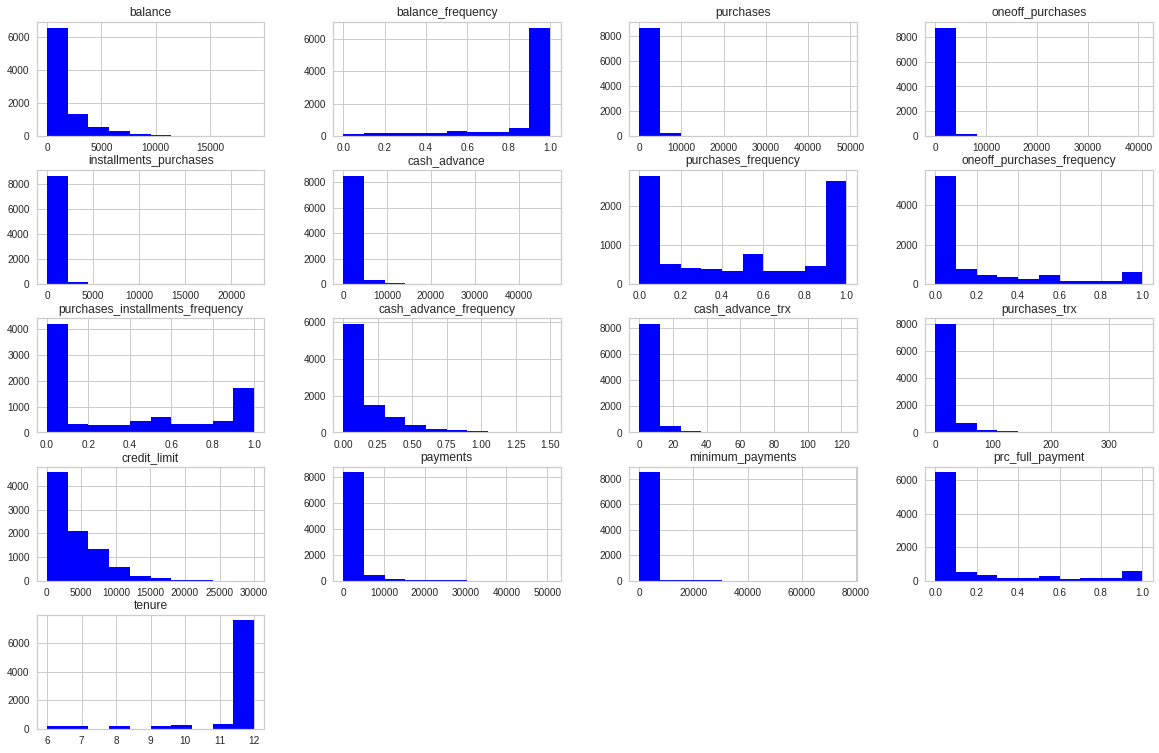

In [11]:
df.hist(figsize=(20,13), color='blue');

> Conclusion for Data's Distribution
> 1. All data represents skew, no normal distributions.
> 2. Balance
>> Look at our balance's distribution. Most of our client keep their balance at low (nearly 0). [Investopedia](https://www.investopedia.com/terms/c/credit-card-balance.asp) says The balance on your credit card is the total amount of money you owe to your credit card issue. This means, our customer is a `clever customer` since they dont owe any money to the bank, or probably because they don't use their credit card.
> 3. Balance Frequency.
>> Since the distribtuion mostly happen at 1 (means: Yes), we can assume that our customer mostly use their CC. Relate to balance is nearly to zero, then our customer frequently use their credit card and pay it back.
> 4. Purchases, oneoffpurchases, and installment_purchases
>> These 3 terms have similar definition. Since it's distributed in low value, means they don't really like to purchase too much but they still do some purchase. But if we took advantage to see the **purchase frequency** then and saw it as evenly distributed between 0 and 1, we can assume that actually people sometimes buy, sometimes dont. But the amount of items they bought (purchases) is different . This conclude one thing : our customer always pay their balance and use their CC evenly with low amount of purchases.
> 5. Cash Advance.
>> [Investopedia](https://www.investopedia.com/terms/c/cashadvance.asp) again says that this is amount of money cust took from their credit card. The distritbution for this column is distributed on low value. Means, customer rarely took their cash from CC.
>6. credit_limit 
>> from our customer is pretty much tidy since our customer prefer to keep their credit_limit low. This maybe because our customer's rank doesn't allow their CC to have higher credit_limit

Now the rest of the distribution is dependent with those columns I explained above, it might need another visualizations.


Text(0.5, 0, 'Purchases')

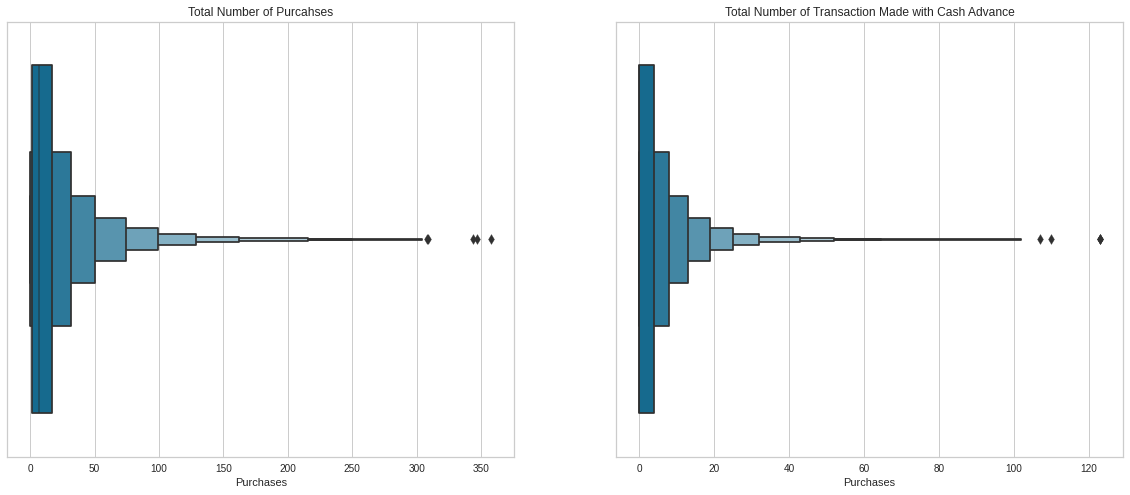

In [12]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxenplot(df['purchases_trx'])
plt.title('Total Number of Purcahses')
plt.xlabel('Purchases')

plt.subplot(1,2,2)
sns.boxenplot(df['cash_advance_trx'])
plt.title('Total Number of Transaction Made with Cash Advance')
plt.xlabel('Purchases')


> Here we can say our customer mostly do purchase without cash (since cash only have 120x of purchase)

Text(0.5, 0, 'Purchases')

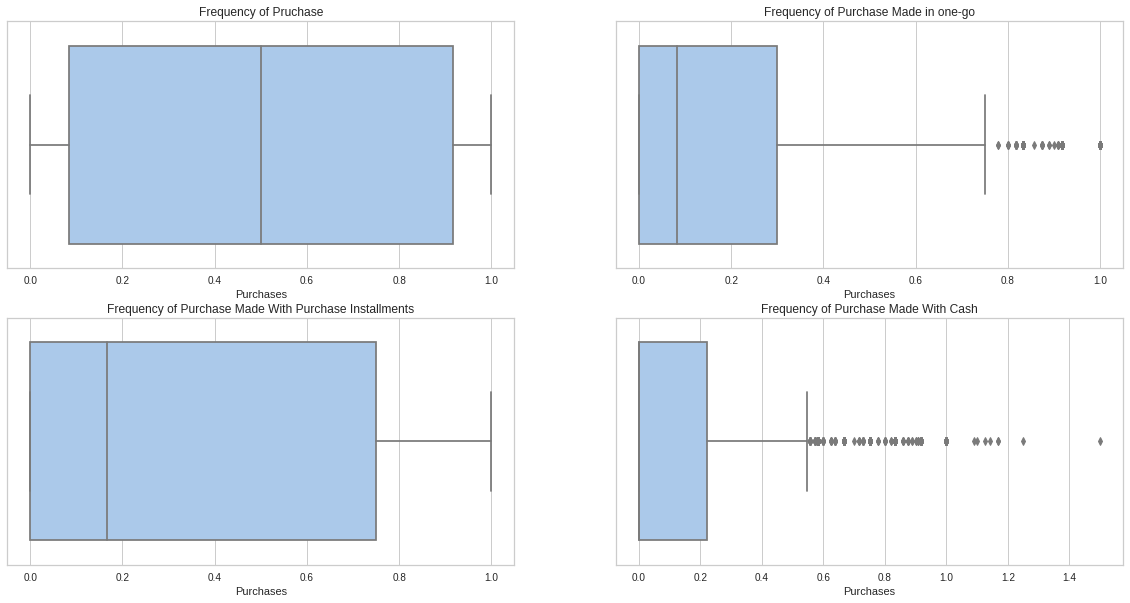

In [13]:
plt.figure(figsize=(20,10))
sns.set_palette("pastel")
plt.subplot(2,2,1)
sns.boxplot(df['purchases_frequency'])
plt.title('Frequency of Pruchase')
plt.xlabel('Purchases')

plt.subplot(2,2,2)
sns.boxplot(df['oneoff_purchases_frequency'])
plt.title('Frequency of Purchase Made in one-go')
plt.xlabel('Purchases')

plt.subplot(2,2,3)
sns.boxplot(df['purchases_installments_frequency'])
plt.title('Frequency of Purchase Made With Purchase Installments')
plt.xlabel('Purchases')


plt.subplot(2,2,4)
sns.boxplot(df['cash_advance_frequency'])
plt.title('Frequency of Purchase Made With Cash')
plt.xlabel('Purchases')

> These visualization resulths the same as above, mostly our customer do love purchase without case. But this time it shows that they like to purcahse with purchase installments. I assume it happens because no one likes complicated methods to pay. Customer prefer installments because it repaid monthly and regulary scheduled payments.

# 5. Data Preprocessing
Our data only have numeric, hence we only need scaler without encode.

## Split Data

In [14]:
df_inf = df.sample(200, random_state=5)
df = df.drop(df_inf.index)

## Handling Outlier
I already state above taht in this case, we have no outliers.

## Handling Missing Value
As i've wrote before, 
> 1. i'll replace the NaN  in minimum_payment into 0 value assuming they don't do any payments. In case they have done payments, then the missing value will be rpelaced with their `payments` instead of 0
> 2. I'll drop the credit_limit missing value because it only have 1 missing value

In [15]:
# 1. 
df['minimum_payments_'] = df['minimum_payments'].fillna(df['payments'])

In [16]:
df = df.drop(['minimum_payments'], axis=1)

In [17]:
#2.
df.dropna(inplace=True)

In [18]:
df.isna().sum()

balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
prc_full_payment                    0
tenure                              0
minimum_payments_                   0
dtype: int64

Now our data is clean for the missing value

## Scaling

In [20]:
scaler = MinMaxScaler() #my data is skew, i prefer to use min max scaler
scaler.fit(df)

df_scaled = scaler.transform(df)

## VIF Score
VIF score use to see if we can reduce our component to specific value or not

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

vif_data.sort_values(by='VIF')

,feature,VIF
16,minimum_payments_,1.394566
14,prc_full_payment,1.693545
5,cash_advance,3.435573
13,payments,3.598904
10,cash_advance_trx,3.867246
0,balance,4.084870
11,purchases_trx,4.227487
12,credit_limit,4.620129
9,cash_advance_frequency,4.913131
7,oneoff_purchases_frequency,5.687539


> from VIF score we can conclude : 
>> - Threhsold for VIF is 5. All features with score > 5 will be discarded
>> - There are only 9 columns scored less than 5 from 17 columns 
>> - The columns are balance, cash_advance, cash_advance_frequency, cash_advance_trx, purchase_trx, payments, prc_full_payments, minimum_payments_, and credit_limit_

In [22]:
# Reduce Component to 10 
pca =PCA(n_components=10)
pca.fit(df_scaled) #why 10 ? 9 as independent feature, 1 to represents the dependent feature

PCA(n_components=10)

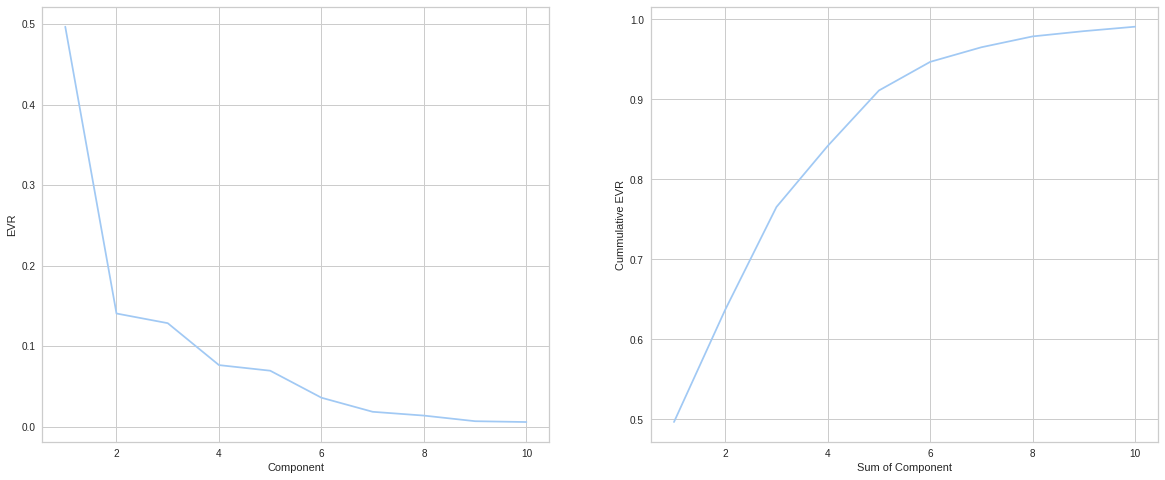

In [23]:
#visualize the EVR
fig,ax=plt.subplots(ncols=2,figsize=(20,8))
ax[0].plot(range(1,11), pca.explained_variance_ratio_)
ax[0].set_xlabel('Component')
ax[0].set_ylabel('EVR')
plt.grid()

ax[1].plot(range(1,11),np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Sum of Component')
ax[1].set_ylabel('Cummulative EVR')
plt.grid()

> - I think the elbow is at component = 2, but the cumulative EVR of 3 component is only represents 0.6 of the data. This is not signicificant.
> - Then I'll take 9 as our component

In [24]:
#reduce the feature in dataset
df_reduced = pca.transform(df_scaled)

# 6. Model Definition
I use 3 models : KMeans, DBSCAN, and Agglomerative with their default parameters. Later on I'll select the best one and set hyperparameter for it

In [25]:
kmeans = KMeans()

In [26]:
dbs = DBSCAN()

In [27]:
agg = AgglomerativeClustering()

# 7. Model Training

In [28]:
kmeans.fit(df_reduced)
dbs.fit(df_reduced)
agg.fit(df_reduced)

AgglomerativeClustering()

# 8. Model Evaluation
In order to evaluate model in unsupervised machine learning, I need to visualize my data into Two Dimension and decide if the cluster separated evenly or not.

In [29]:
vis_2d = PCA(n_components=2).fit_transform(df_reduced)

Text(0.5, 1.0, 'KMeans')

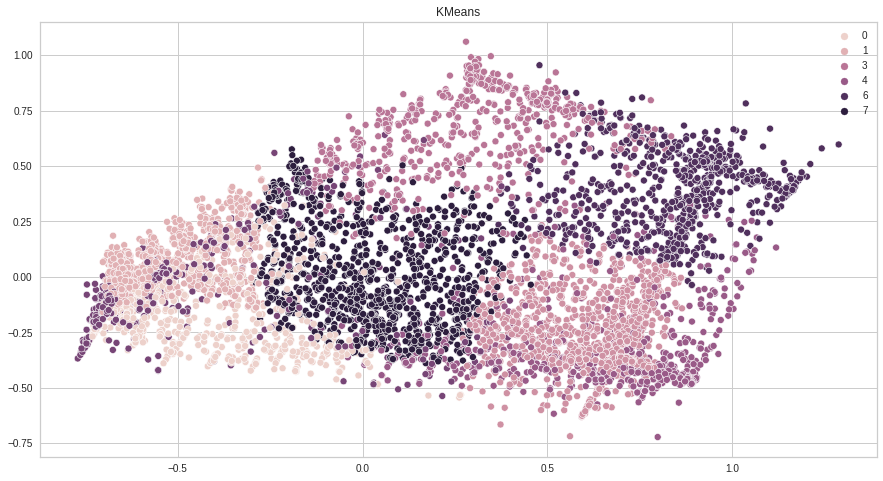

In [30]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=vis_2d[:,0],y=vis_2d[:,1],hue=kmeans.labels_).set_title('KMeans')

> By Default, KMeans divide into 8 clusters. From the visualization what I see is the cluster is not good enough. The model seems fail to cluster the data. This needs evaluation on finding the K

Text(0.5, 1.0, 'DBSCAN')

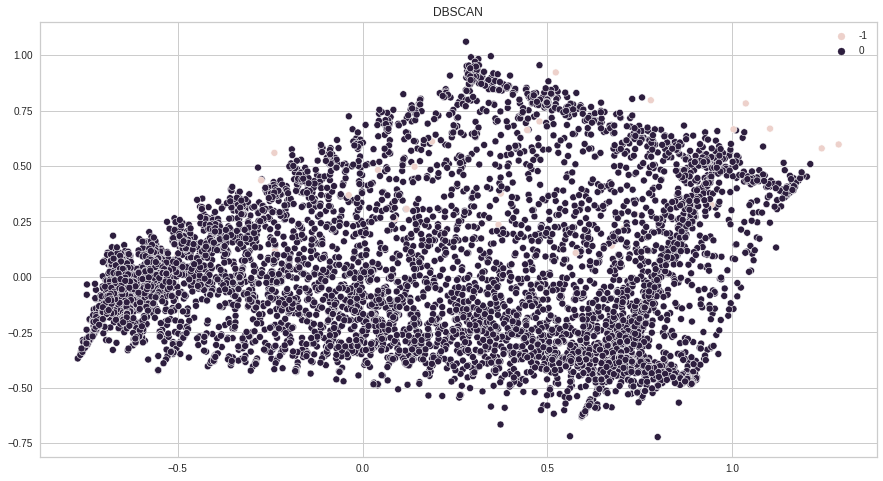

In [31]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=vis_2d[:,0],y=vis_2d[:,1],hue=dbs.labels_).set_title('DBSCAN')
# plt.scatter(dbs.core_sample_indices_, c = 'yellow', label = 'core')

> By default, DBSCAN use 0.5 epsilon with 5 min_samples. This totally wrong because we can see there's only one cluster, why would we do clustering then? I'll use the concept of nearestneighbor to evaluate the model

Text(0.5, 1.0, 'Agglomerative Clustering')

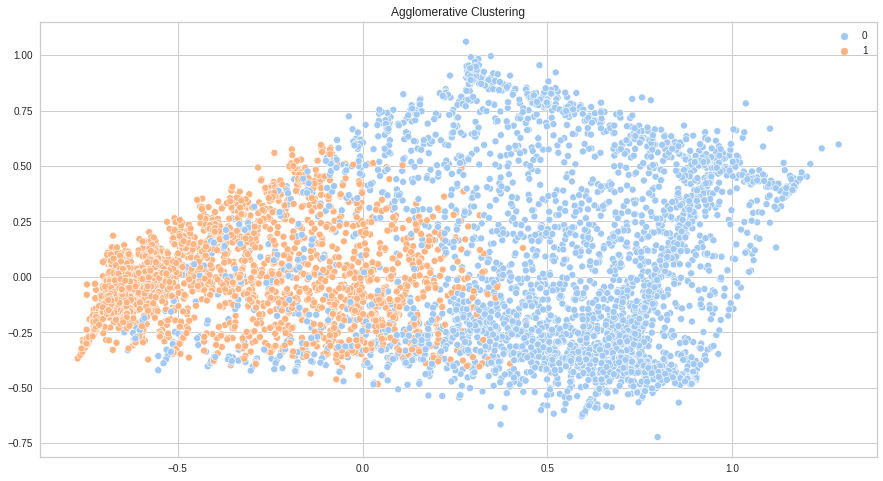

In [32]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=vis_2d[:,0],y=vis_2d[:,1],hue=agg.labels_).set_title('Agglomerative Clustering')

> I Actually think that using Agglomerative parameter default is already good, since it can classified each cluster clearlny. But having only 2 clusters seems too homogen for me. I'll still find to hyperparameter for this models

## K Means

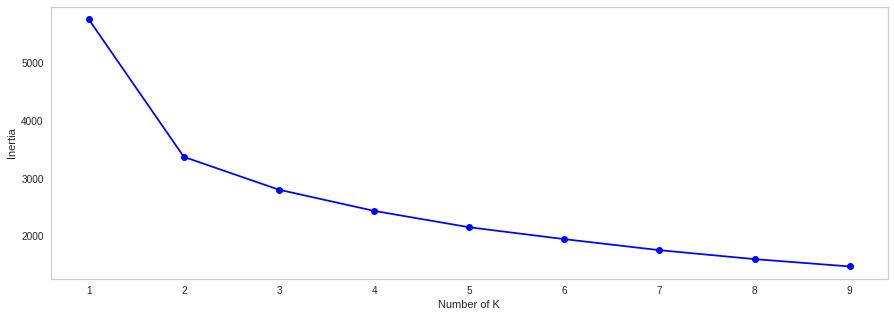

In [33]:
kmeans_models = [KMeans(n_clusters=k, random_state=5).fit(df_reduced) for k in range (1, 10)]
K_inertia = [model.inertia_ for model in kmeans_models]

plt.figure(figsize=(15, 5))
plt.plot(range(1,10), K_inertia, color='blue', marker='o')
plt.xlabel('Number of K')
plt.ylabel('Inertia')
plt.grid()
plt.show()

>  This Elbow is too smooth, it's hard for me to find the elbow. I assume it's 2 of K. I'll take silhouette as my 2nd helper to decide K

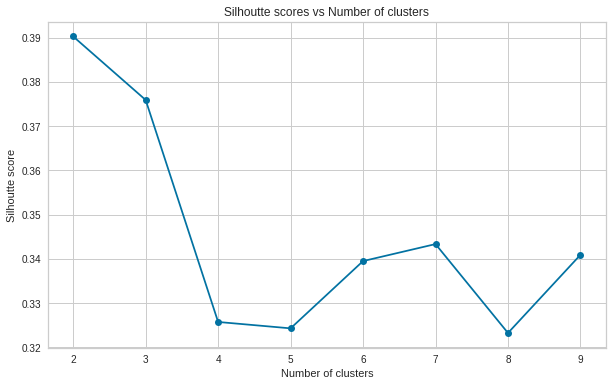

In [34]:
silhoutte_scores = [silhouette_score(df_reduced, model.labels_) for model in kmeans_models[1:]]

plt.figure(figsize=(10,6))
plt.plot(range(2,10), silhoutte_scores, "bo-")
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

> Silhouette helps. I'll take 3 as our numbre of cluster since it  has the highest silhouette score. Even tho 7 represent higher silhouette, but it wont be significant for our clusters since it represents similar silhouette scores with 3 clusters

In [35]:
kmeans_ = KMeans(n_clusters = 3 , init = "k-means++", n_init=10, random_state=5)
kmeans_.fit(df_reduced)
# dbs.fit(df_reduced)

KMeans(n_clusters=3, random_state=5)

Text(0.5, 1.0, 'KMeans With Elbow')

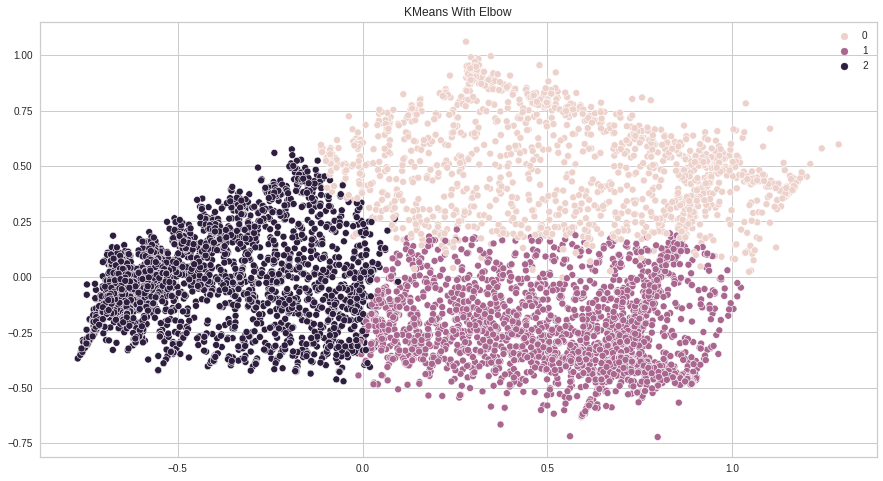

In [36]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=vis_2d[:,0],y=vis_2d[:,1],hue=kmeans_.labels_).set_title('KMeans With Elbow')
# plt.scatter(kmeans_.cluster_centers_[:, 0], kmeans_.cluster_centers_[:, 1], s=200, c = 'yellow', label = 'centroids')

> The elbow and silkhouette helps the model to cluster better, this means for our customer segmentation using KMaeans model, we have 3 clusters

## DBSCAN

In [37]:
# silhouette_dbscan = []

# for eps in np.arange(0.1, 3, 0.1):
#     for min_sample in range(1,15):
#         dbscan = DBSCAN(eps=eps, min_samples= min_sample)
#         dbscan.fit(df_reduced)
#         sil_dbscan = silhouette_score(df_reduced, dbscan.labels_, metric='euclidean')
#         silhouette_dbscan.append((eps, min_sample, sil_dbscan, len(set(dbscan.labels_))) )

> Even when I'm trying to evaluate and find the best silhouette score through epsilon & min_samples parameters. As the error says `Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)` this means in that parameter range only resulting only 1 cluster, therefore it caused error.

> I Assume this happens becaue DBSCAN is not a right model for our dataset. This happened because our datasets is skew and the data distributed uneven.

## Agglomerative

In [38]:
linkages = ["ward", "single", "average"]
silhouette_agg = []
for i in range(2,11):
  for lk in linkages:
    agg = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=lk)
    agg.fit(df_reduced)
    sil_agg=silhouette_score(df_reduced, agg.labels_)
    silhouette_agg.append((i, lk, sil_agg))
pd.DataFrame(silhouette_agg, columns=['n_cluster','linkage','silhouette_score']).sort_values(by='silhouette_score')

,n_cluster,linkage,silhouette_score
25,10,single,0.109379
22,9,single,0.127814
14,6,average,0.194833
11,5,average,0.200624
19,8,single,0.209819
16,7,single,0.218681
8,4,average,0.227457
13,6,single,0.231041
10,5,single,0.232492
7,4,single,0.236365


> The best results for silhouette scores is  n_clusters = 2, linkage= single, with 0.359 silhouette score

In [39]:
agg_ = AgglomerativeClustering(n_clusters = 2 , linkage='single')
agg_.fit(df_reduced)

AgglomerativeClustering(linkage='single')

Text(0.5, 1.0, 'Agglomerative Clustering')

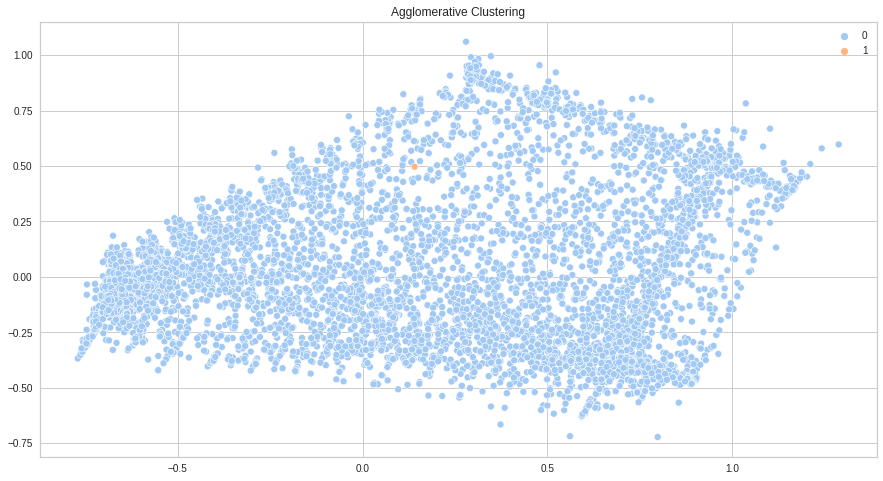

In [40]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=vis_2d[:,0],y=vis_2d[:,1],hue=agg_.labels_).set_title('Agglomerative Clustering')

> My Agglomerative with hyperparam went worse. I assume this happened because the weight of the clusters is imbalance. Yes the silhouette score is highest with linkage=average, but this fail to distinguish the data evenly. I'll stick to the default settings where the clusters is divided to 2

## Clusters EDA
This EDA is using the KMEANS Models since I think the best models is KMeans. Further Explanation explained in 10. Conflusions 

In [41]:
#inserting clusters in our dataframe
_df = df.copy()
_df['cluster'] = kmeans_.labels_
# KMeans(n_clusters=3, random_state=5).fit_predict(df_reduced)
kmean_cluster = _df.groupby('cluster').mean()

In [42]:
kmean_cluster = kmean_cluster.reset_index()
kmean_cluster

,cluster,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,prc_full_payment,tenure,minimum_payments_
0,0,1933.673642,0.973311,3206.869055,2395.018473,811.850582,660.930045,0.893886,0.798720,0.483908,0.093618,2.309659,42.527699,6739.486699,3236.737622,0.270773,11.751420,768.935374
1,1,1142.614067,0.914207,1067.527199,269.689641,798.494196,503.549472,0.870116,0.098707,0.819133,0.070771,1.740388,20.809227,3941.385199,1392.366514,0.237041,11.521055,920.252278
2,2,1705.652700,0.826942,295.501577,232.893607,62.801755,1345.821247,0.143231,0.081604,0.060388,0.185704,4.414751,2.678091,4141.306843,1470.468297,0.068139,11.449241,829.974385


In [43]:
#counting each clusters value
_df.cluster.value_counts()

2    4610
1    2731
0    1408
Name: cluster, dtype: int64

Text(0.5, 1.0, 'Clusters Distribution')

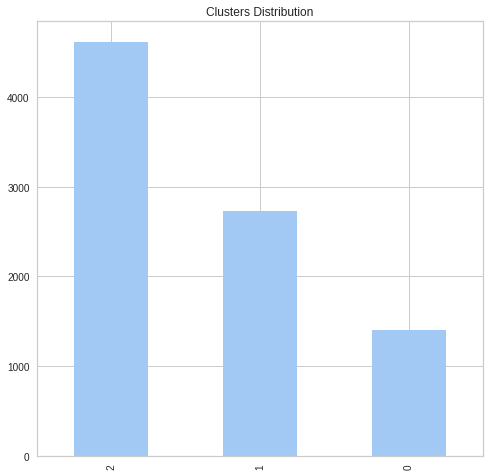

In [44]:
_df.cluster.value_counts().plot(kind='bar', figsize=(8,8))
plt.title('Clusters Distribution')

> - There are 4.610 data in cluster 2 (around 4.6k)
> - 2.731 data in cluster 1 (around 2.7k),
> - 1.409 data in cluster 0 (around 1.4k), 

Note: The data might changed, but the cluster's count remain similar

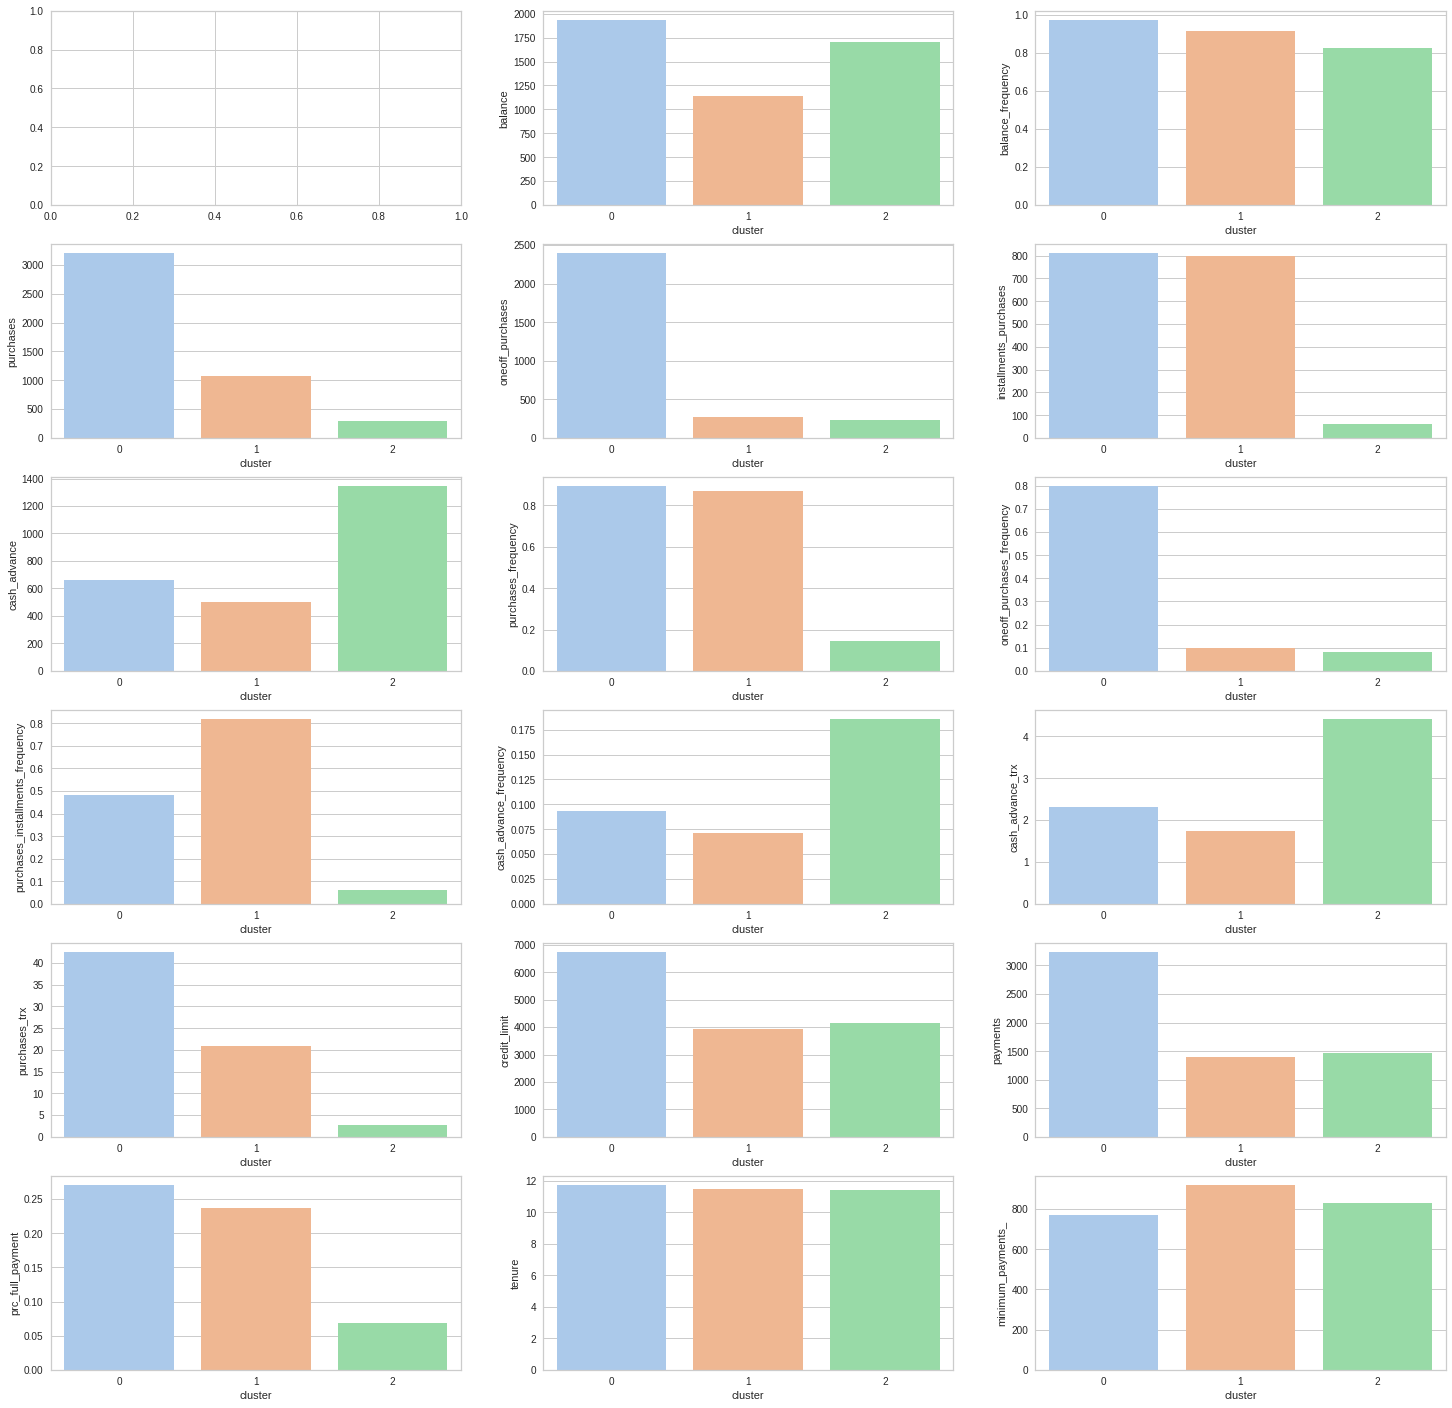

In [45]:
# plot distribution of each feature to analyze

fig, axs = plt.subplots(round(len(kmean_cluster.columns)/3), 3, figsize=(25,25))
for i in range(len(kmean_cluster.columns)):
  # for k in columns:
  if kmean_cluster.columns[i] != 'cluster':
    sns.barplot(x=kmean_cluster['cluster'], y= kmean_cluster[kmean_cluster.columns[i]], ax=axs[i//3, i%3])


EDA RESULTS: 

**The cluster's name might change if we re run the progress, but the results are always like this **
> I'd like to give you the summary of all columns here.
>>  BALANCE : Balance amount left in their account to make purchases
>> - highest = 1 
>> - lowest = 2

>> BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
>> - highest = 1
>> - lowest = 0

>> PURCHASES : Amount of purchases made from account
>> - highest = 1
>> - lowest = 0

>> ONEOFFPURCHASES : Maximum purchase amount done in one-go
>> - highest = 1
>> - lowest = both


>> INSTALLMENTSPURCHASES : Amount of purchase done in installment
>> - highest = 1
>> - lowest = 0

>> CASHADVANCE : Cash in advance given by the user
>> - highest = 0
>> - lowest = 2

>> PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
>> - highest = 1 similar to 2
>> - lowest = 0

>> ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
>> - highest = 1
>> - lowest = both


>> PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
>> - highest = 2
>> - lowest = 0

>> CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
>> -highest = 0
>> - lowest = 2

>> CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
>> highest = 0
>> lowest = 2

>> PURCHASESTRX : Numbe of purchase transactions made
>> - highest = 1
>> - lowest = 0


>> CREDITLIMIT : Limit of Credit Card for user
>> - highest = 1
>> - lowest = 2

>> PAYMENTS : Amount of Payment done by user
>> - highest = 1
>> - lowest = 2

>> MINIMUM_PAYMENTS : Minimum amount of payments made by user
>> - highest = 2
>> - lowest = 1

>> PRCFULLPAYMENT : Percent of full payment paid by user
>> - highest = 1
>> - lowest = 0

>> TENURE : Tenure of credit card service for user
>> - highest = same
>> - lowest = same

Those means the behaviour of each clusters are 

1. Cluster 0 = People who use cash_advace as their method of payments, therefore we can't track much for their CC trx further : **Cash Advance Type Of Customer**
2. Cluster 2 = People who barely use cash advance and prefer to use installment/oneoff but they have low balance, this cluster is in the middle of spending and using their CC : **Basic Customer**
3. Cluster 1 = People who have high balance and credit_limit, they like to purchase things with their CC : **Gold Customer**

Tjere are **Cash Advance Customer, Basic Customer, and Gold Customer** and in this datasets we have lots of customer in **Cash Advance** clusters

# 9. Model Inference

In [46]:
#Check missing value in df_inf
df_inf.isna().sum()

balance                              0
balance_frequency                    0
purchases                            0
oneoff_purchases                     0
installments_purchases               0
cash_advance                         0
purchases_frequency                  0
oneoff_purchases_frequency           0
purchases_installments_frequency     0
cash_advance_frequency               0
cash_advance_trx                     0
purchases_trx                        0
credit_limit                         0
payments                             0
minimum_payments                    11
prc_full_payment                     0
tenure                               0
dtype: int64

> our df_inf have missing value, need to handle it

## Handle Missing Value

In [47]:
df_inf['minimum_payments_'] = df_inf['minimum_payments'].fillna(df_inf['payments'])
df_inf = df_inf.drop('minimum_payments', axis=1)

## Scaling

In [48]:
df_inf_scaled = scaler.transform(df_inf)

In [49]:
df_inf_reduced = pca.transform(df_inf_scaled)

## Model Training

For Inference model, I can only use KMEans model. Because **DBSCAN & AGGLOMERATIVE** have no methode `.predict`. This means, for DBSCAN and AgglomerativeClustering need to re-model everytime we got new data

In [50]:
vis_2d_inf = PCA(n_components=2).fit_transform(df_inf_scaled)

## KMeans

In [51]:
kmeans_inf_pred= kmeans_.predict(df_inf_reduced)

## Results in Inference

In [52]:
df_inf['cluster_kmeans'] = kmeans_inf_pred
kmean_cluster_inf = df_inf.groupby('cluster_kmeans').mean()

In [53]:
kmean_cluster_inf = kmean_cluster_inf.reset_index()

In [54]:
kmean_cluster_inf

,cluster_kmeans,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,prc_full_payment,tenure,minimum_payments_
0,0,1580.171317,0.989610,2879.386571,2364.851429,514.535143,577.973948,0.876698,0.800971,0.395795,0.090816,3.428571,37.914286,5445.714286,3069.150381,0.291407,11.771429,690.186850
1,1,952.407199,0.896139,966.984423,202.552692,764.431731,469.433032,0.897092,0.089896,0.834257,0.067628,1.211538,18.807692,4159.615385,1329.109987,0.271626,11.211538,616.582016
2,2,1690.705152,0.803976,306.821770,235.964425,70.857345,1823.459612,0.142759,0.079022,0.068099,0.190219,4.743363,2.592920,4153.834808,1737.664439,0.076953,11.398230,767.631490


# 10. Conclusions

From all of the model I used (KMeans, DBSCAN, and AgglomerativeClustering) the best model is **KMeans**. 

KMeans have 0.33 SIlhouette with 3 clusters, yet AgglomerativeClustering have 0.35 siilhouette score with 2 clusters. When we have too small cluster, it means the data is homogen and clustering is not really useful then.

DBSCAN is not a good methode to use in this datasets because [sklearn](https://scikit-learn.org/stable/modules/clustering.html) says the usecase of DBSCAN is when the data is Non-flat geometry, hence our data is a flat-geometry.

With KMeans (n_clusters = 3) the results is:
> The highest amount of customer is **Cash Advance** title, and the lowest is **Gold Customer**. 
> 1.  **Cash Advance**  = People who use cash_advace as their method of payments, therefore we can't track much for their CC trx further
> 2. **Basic Customer** = People who barely use cash advance and prefer to use installment/oneoff but they have low balance, this cluster is in the middle of spending and using their CC 
> 3. **Gold Customer** = People who have high balance and credit_limit, they like to purchase things with their CC